In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from itertools import permutations, product
import functools
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score
import tqdm
from numba import njit,jit
import numpy as np
from numpy import mean
from numpy import std
import pickle
from os import path
from sklearn.model_selection import cross_val_score
from warnings import simplefilter
from collections import OrderedDict
import matplotlib.pyplot as plt
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)



In [2]:
df = pd.read_csv('virus_genome/human_infecting_virus', delimiter='\t', header=None)
df[['ID', 'DNA Sequence']] = df[0].str.split(expand=True)
df = df.drop(0, axis=1)
df['isZoonotic'] = 1


df2 = pd.read_csv('virus_genome/Other_viruses', delimiter='\t', header=None)
df2[['ID', 'DNA Sequence']] = df2[0].str.split(expand=True)
df2 = df2.drop(0, axis=1)
df2['isZoonotic'] = 0

# make both have the same amount of samples..?

thresh = len(df)
# df2.drop(df2.index[thresh:len(df2.index)], inplace=True)

dfother = pd.DataFrame()
it = len(df)+1

print(len(df))
print(len(df2))
# iterate through each sequence
for i in range(len(df2)):
    dfother.at[it, 'DNA Sequence']=df2.at[i, 'DNA Sequence']
    dfother.at[it, 'isZoonotic']=int(0)
    dfother.at[it, 'ID']=df2.at[i, 'ID']
    it+=1


mergedDf = pd.concat([df, dfother], axis=0)


1236
8192


In [3]:
def resetkmerdict(permset)->OrderedDict:
        kmerdict = OrderedDict()
        for i in permset:
            kmerdict[i]=0
        return kmerdict

def assign_kmers_to_dict(row, permset, kmer):
    kmerdict=resetkmerdict(permset)
    st = row[2] # tune for which column the sequence is in
    for j in range(len(st)-kmer+1):
        if not st[j:j+kmer] in permset: continue
        kmerdict[st[j:j+kmer]]+=1
    return kmerdict

def getTrainParams(mergedDf):
    kmer = 4
    print(mergedDf)
    s = product('acgt',repeat = kmer)
    permset = set(["".join(x) for x in list(s)])

    l = []
    
    for row in tqdm.tqdm(mergedDf.itertuples()):
        l.append(assign_kmers_to_dict(row, permset, kmer))
        

    finalkmerdict=pd.DataFrame(l)
    mergedDf.fillna(0, inplace=True)

    X = finalkmerdict
    Y = mergedDf['isZoonotic']

    print(X)
    print(Y)
    return train_test_split(X, Y, test_size=0.2, random_state=1)

In [4]:
X_train, X_test, y_train, y_test = getTrainParams(mergedDf)

zz = X_train.head()


           ID                                       DNA Sequence  isZoonotic
0       37121  cttttaacaatcatagttttataaaagggtgtaaccgaagcggttt...         1.0
1      129724  atactttacaattatcttgtaaaaagtagggtgtaaccgaaaaggg...         1.0
2       59303  atggcggacgtgtgacatcaccgttcgctctttctaggatcctttg...         1.0
3      120686  ttgttctacttcttactcattattataaattataatgtttgtataa...         1.0
4       99565  gtgaatgatgatggcgtcgaaagacgtcgttgcagctactgctgct...         1.0
...       ...                                                ...         ...
9424   268315  ggatccacagaactccttgtatgtacagccgcgggtacccacagca...         0.0
9425   130329  ctcatgtcattaataagaccatgcagaaaatgcaaatgaggcgaag...         0.0
9426  1239437  ccgaagtgggatggcggctgccgccgcttcggcgcttggcgcttcg...         0.0
9427   358812  gtatacgaggttagttcattctcgtatacacgattggacaaatcaa...         0.0
9428    11287  atggaaggaggaattcgtgcagcgttttcaggcctgaatgatgtta...         0.0

[9428 rows x 3 columns]


9428it [01:41, 92.99it/s] 


      attt  taag  cgat  ttat  tgca  aact  aatg  ctcg  ctga  gacg  ...  accg  \
0       79    30     9    68    58    26    49     3    22    13  ...     8   
1       87    24     8    74    65    32    55     6    26    10  ...     9   
2       20    33    27    15    73    42    49    23    50    66  ...    76   
3       60    26    10    55    69    23    43     7    25    19  ...    13   
4       41    17     6    40    34    29    46    10    33     5  ...     8   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
9423    24     8     7    12    10     9    16     7    18    10  ...     9   
9424   317   123    70   188   183   122   224    53   129    67  ...    93   
9425    44    31     4    30    33    39    35    12    36     6  ...    10   
9426    56    47    23    50    47    59    57     9    66    30  ...    23   
9427    23    12    23    10    40    46    41    35    44    32  ...    29   

      ggag  acaa  gata  tcct  aacc  gatt  tacc  act

In [5]:
model = LogisticRegression(
    multi_class="multinomial", max_iter=1000,
    fit_intercept=False, tol=0.001, solver='saga', random_state=42)
model.fit(X_train, y_train)

LogisticRegression(fit_intercept=False, max_iter=1000,
                   multi_class='multinomial', random_state=42, solver='saga',
                   tol=0.001)

In [6]:
# all 0s for some reason
print(X_test[:10])
predictions = model.predict(X_test)
print(accuracy_score(y_test, predictions))

      attt  taag  cgat  ttat  tgca  aact  aatg  ctcg  ctga  gacg  ...  accg  \
1302    27    13     5    14    11    11    20     6    13     4  ...     8   
6596   110    53    49    62    48    43    60    20    41    14  ...    12   
4095    26     9     8    18     9    10    15     5     9     5  ...     2   
7284  1947   314   809   887   733   863   939   462   573   429  ...   488   
4899    90    39    38   120    33    70    75    30    57    19  ...    23   
6289    73    31    28    62    47    60    75    12    48    31  ...    12   
7830    11    10   349     4   104   113    38   517   204   532  ...   502   
2048    40    44   354    16   106   114    25   532   277   484  ...   447   
7122   450   159    53   360   124   252   319    15   150    63  ...    32   
7488    11     7     2     9    11    11     9     4    16     7  ...     6   

      ggag  acaa  gata  tcct  aacc  gatt  tacc  actc  gatc  
1302     8     7    10    18     6    22     4     8     8  
6596    

In [7]:
knntest = BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors = 1, n_jobs = 1), n_estimators = 10, n_jobs = 1)

knntest.fit(X_train, y_train)
# knn = KNeighborsClassifier(n_neighbors=5)

BalancedBaggingClassifier(base_estimator=KNeighborsClassifier(n_jobs=1,
                                                              n_neighbors=1),
                          n_jobs=1)

In [8]:
predictions = knntest.predict(X_test)
print(predictions[:10])
print(accuracy_score(y_test, predictions))

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0.9146341463414634


In [9]:

randforest = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features="sqrt"))

randforest.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='sqrt'))

In [18]:
def saveModel(model, name, X_test, y_test, params=None, dir='curr_models', gradBoost=False, xgBoost=False):
    predictions = model.predict(X_test)
    currAcc = accuracy_score(y_test, predictions)
    
    print(confusion_matrix(y_test, predictions))
    
    if not path.exists(f"{dir}/{name}.pkl"):
        print("does not exist")

        pickle.dump(model, open(f'{dir}/{name}.pkl', 'wb'))
    else:
        pickled_model = pickle.load(open(f'{dir}/{name}.pkl', 'rb'))
        if gradBoost:
            # get features here 
            cols_when_model_builds = pickled_model.feature_names_in_
            X_test=X_test[cols_when_model_builds]
        elif xgBoost:
            # put features into the same order that the model was trained in
            cols_when_model_builds = pickled_model.get_booster().feature_names
            X_test=X_test[cols_when_model_builds]
        
        picklePredictions=pickled_model.predict(X_test)
        pickleAcc=accuracy_score(y_test, picklePredictions)
        
        if currAcc > pickleAcc:
            print("update!")
            print(confusion_matrix(y_test, picklePredictions))

            print("curr", currAcc, "pickle", pickleAcc)
            pickle.dump(model, open(f'{dir}/{name}.pkl', 'wb'))

            if params != None:
                pickle.dump(params, open(f'{dir}/{name}-params.pkl', 'wb'))
        else:
            print("no update")
            print("curr", currAcc, "pickle", pickleAcc)
            model=pickled_model
    return model

In [11]:
saveModel(randforest, "randforest", X_test, y_test)

predictions = randforest.predict(X_test)
print(accuracy_score(y_test, predictions))

# for i in range(1000):
#     predictions[i] != y_test_list[i] and print(predictions[i], "vs", y_test_list[i])

[[1564   70]
 [  36  216]]
update!
[[1609   25]
 [ 251    1]]
curr 0.943796394485684 pickle 0.8536585365853658
0.943796394485684


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [12]:
probability_predictions = randforest.predict_proba(X_test)
preds = randforest.predict(X_test)
print(accuracy_score(y_test, preds))


0.943796394485684


In [19]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   "n_estimators":100, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":6,
    "random_state":0,
    "min_sample_split":50,
    "subsample":0.8,
    "warm_start":True
}



for learning_rate in lr_list:
    gradBoost = GradientBoostingClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, max_features=parameters['max_features'], 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    min_samples_split=parameters['min_sample_split'], subsample=parameters['subsample'], 
    warm_start=parameters['warm_start'])

    parameters['learning_rate']=learning_rate
    gradBoost.fit(X_train, y_train)

    testingAcc = accuracy_score(y_test, gradBoost.predict(X_test))
    trainingAcc = accuracy_score(y_train, gradBoost.predict(X_train))
    
    print("Learning rate: ", learning_rate)
    # print("Accuracy score (training): {0:.3f}".format(trainingAcc))
    print("Accuracy score (validation): {0:.3f}".format(testingAcc))
    # print(f"Feature importance {gradBoost.feature_importances_}")

    # pickle.dump(gradBoost, open('gradBoost.pkl', 'wb'))
    saveModel(gradBoost, "gradBoost", X_test, y_test, parameters, gradBoost=True)

Learning rate:  0.05
Accuracy score (validation): 0.955
[[1624   10]
 [  75  177]]
no update
curr 0.954931071049841 pickle 0.9623541887592789
Learning rate:  0.075
Accuracy score (validation): 0.957
[[1622   12]
 [  70  182]]
no update
curr 0.9565217391304348 pickle 0.9623541887592789
Learning rate:  0.1
Accuracy score (validation): 0.957
[[1618   16]
 [  66  186]]
no update
curr 0.9565217391304348 pickle 0.9623541887592789
Learning rate:  0.15
Accuracy score (validation): 0.960
[[1616   18]
 [  58  194]]
no update
curr 0.9597030752916225 pickle 0.9623541887592789
Learning rate:  0.2
Accuracy score (validation): 0.959
[[1621   13]
 [  65  187]]
no update
curr 0.95864262990456 pickle 0.9623541887592789
Learning rate:  0.25
Accuracy score (validation): 0.956
[[1613   21]
 [  62  190]]
no update
curr 0.9559915164369035 pickle 0.9623541887592789
Learning rate:  0.3
Accuracy score (validation): 0.959
[[1616   18]
 [  60  192]]
no update
curr 0.95864262990456 pickle 0.9623541887592789
Learni

In [14]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   "n_estimators":100, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":6,
    "random_state":0,
    "min_sample_split":50,
    "subsample":0.8,
    "warm_start":True
}



for learning_rate in lr_list:
    xgBoost = XGBClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    subsample=parameters['subsample'], 
    )

    parameters['learning_rate']=learning_rate
    xgBoost.fit(X_train, y_train)

    testingAcc = accuracy_score(y_test, xgBoost.predict(X_test))
    trainingAcc = accuracy_score(y_train, xgBoost.predict(X_train))
    
    print("Learning rate: ", learning_rate)
    # print("Accuracy score (training): {0:.3f}".format(trainingAcc))
    print("Accuracy score (validation): {0:.3f}".format(testingAcc))
    # print(f"Feature importance {gradBoost.feature_importances_}")

    # pickle.dump(gradBoost, open('gradBoost.pkl', 'wb'))
    saveModel(xgBoost, "xgBoost", X_test, y_test, parameters, xgBoost=True)

Learning rate:  0.05
Accuracy score (validation): 0.957
[[1622   12]
 [  70  182]]
no update
curr 0.9565217391304348 pickle 0.9655355249204666
Learning rate:  0.075
Accuracy score (validation): 0.961
[[1624   10]
 [  63  189]]
no update
curr 0.9612937433722163 pickle 0.9655355249204666
Learning rate:  0.1
Accuracy score (validation): 0.961
[[1622   12]
 [  61  191]]
no update
curr 0.9612937433722163 pickle 0.9655355249204666
Learning rate:  0.15
Accuracy score (validation): 0.962
[[1622   12]
 [  59  193]]
no update
curr 0.9623541887592789 pickle 0.9655355249204666
Learning rate:  0.2
Accuracy score (validation): 0.963
[[1622   12]
 [  57  195]]
no update
curr 0.9634146341463414 pickle 0.9655355249204666
Learning rate:  0.25
Accuracy score (validation): 0.963
[[1623   11]
 [  59  193]]
no update
curr 0.9628844114528102 pickle 0.9655355249204666
Learning rate:  0.3
Accuracy score (validation): 0.965
[[1621   13]
 [  53  199]]
no update
curr 0.9650053022269353 pickle 0.9655355249204666
L

In [21]:
# Models within "orig_models" folder have the highest training acc but not as great cross val

best_xgboost = pickle.load(open('curr_models/xgBoost.pkl', 'rb'))
best_xgboost_params = pickle.load(open('curr_models/xgBoost-params.pkl', 'rb'))

best_gradBoost = pickle.load(open('curr_models/gradBoost.pkl', 'rb'))
best_gradBoost_params = pickle.load(open('curr_models/gradBoost-params.pkl', 'rb'))

best_rF = pickle.load(open('curr_models/randforest.pkl', 'rb'))

print(best_xgboost_params)
print(best_gradBoost_params)


# print("Best XG Accuracy: ", accuracy_score(y_test, best_xgboost.predict(X_test)))
# print("Balanced XG Accuracy: ", balanced_accuracy_score(y_test, best_xgboost.predict(X_test)))
cols_when_model_builds = best_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]

print("Best GB Accuracy: ", accuracy_score(y_test, best_gradBoost.predict(X_test)))
print("Balanced GB Accuracy: ", balanced_accuracy_score(y_test, best_gradBoost.predict(X_test)))

print("Best rF Accuracy: ", accuracy_score(y_test, best_rF.predict(X_test)))
print("Balanced rF Accuracy: ", balanced_accuracy_score(y_test, best_rF.predict(X_test)))

{'n_estimators': 100, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'warm_start': True, 'learning_rate': 0.4}
{'n_estimators': 100, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'warm_start': True, 'learning_rate': 0.35}
Best GB Accuracy:  0.9623541887592789
Balanced GB Accuracy:  0.8809426667443804
Best rF Accuracy:  0.8573700954400848
Balanced rF Accuracy:  0.49815430047988185


/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


precision recall: 0.9150372384473479
[0.00045723 0.00013599 0.00065591 ... 0.00053945 0.00509031 0.01590035]


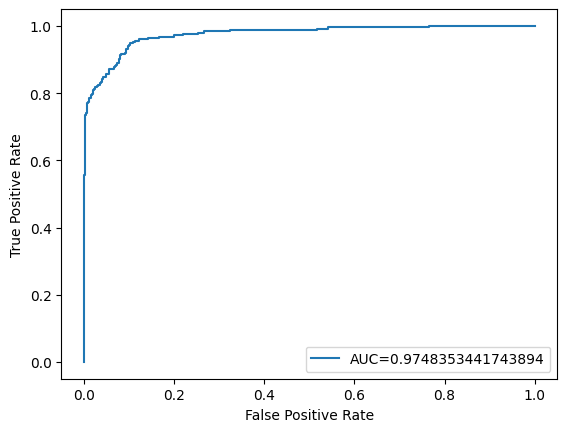

In [ ]:
y_thing = y_test.to_numpy()
precision, recall, thresholds = precision_recall_curve(y_thing, best_gradBoost.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)
print("precision recall: " + str(aaa))

y_pred_proba = best_gradBoost.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()


In [ ]:
y_thing = y_test.to_numpy()
precision, recall, thresholds = precision_recall_curve(y_thing, best_rF.predict(X_test))
area = auc(recall, precision)
print(area)

0.7936120382542234


In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_gradBoost, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.946 (0.014)


In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_rF, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.910 (0.017)
